In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda,BatchNormalization,Activation
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix


import imageio

import matplotlib.pyplot as plt

In [2]:
path = ''
image_path = os.path.join(path, 'dataaa/CameraRGB/')
mask_path = os.path.join(path, 'dataaa/CameraMask/')
image_list_orig = os.listdir(image_path)
mask_list_orig = os.listdir(mask_path)
image_list = [image_path+i for i in image_list_orig if  i.endswith('.png')]
mask_list = [mask_path+i for i in mask_list_orig if i.endswith('.png')]

test_image_path = os.path.join(path, 'test_images/')
test_image_list_orig = os.listdir(test_image_path)
test_image_list = [test_image_path+i for i in test_image_list_orig if i.endswith('.png')]


In [3]:
def process_test_path(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (96, 128))
    return img

# Preprocess testing data
test_image_filenames = tf.constant(test_image_list)

# Convert to TensorFlow Dataset
test_image_ds = tf.data.Dataset.from_tensor_slices(test_image_filenames)

# Apply preprocessing function to the dataset
test_image_ds = test_image_ds.map(process_test_path)


C:\Users\Tanma\AppData\Local\Temp\ipykernel_15660\1645610153.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\Tanma\AppData\Local\Temp\ipykernel_15660\1645610153.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

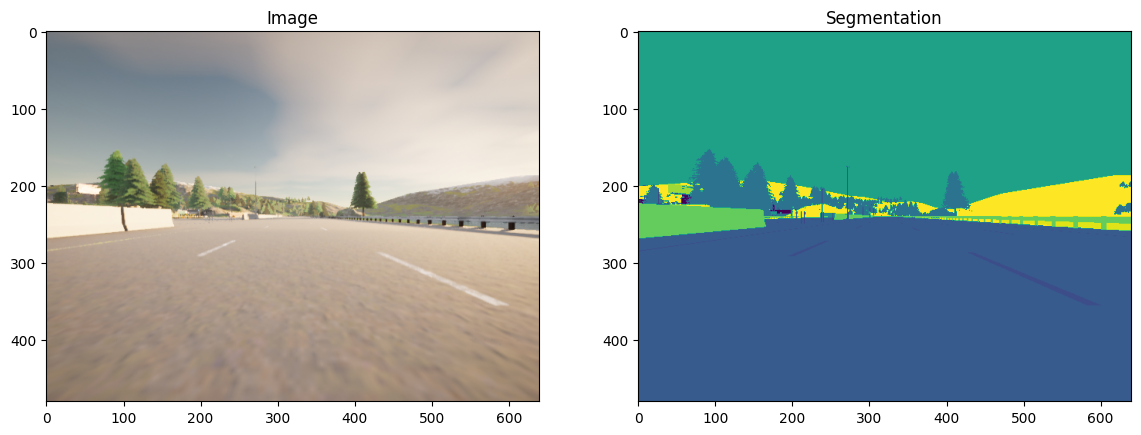

In [4]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [5]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'dataaa\\CameraRGB\\000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'dataaa\\CameraMask\\000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'dataaa\\CameraRGB\\000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'dataaa\\CameraMask\\000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'dataaa\\CameraRGB\\000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'dataaa\\CameraMask\\000028.png'>)


In [6]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

test_filenames = tf.constant(test_image_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))


for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'dataaa/CameraRGB/000026.png', shape=(), dtype=string)
tf.Tensor(b'dataaa/CameraMask/000026.png', shape=(), dtype=string)


In [7]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [8]:
def ghost_block(x, filters, kernel_size=(3, 3), strides=(1, 1), padding='same', dilation_rate=(1, 1)):
    # Ghost convolutional block
    x1 = Conv2D(filters, kernel_size, strides=strides, padding=padding, dilation_rate=dilation_rate)(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    return x1

In [9]:
def ghost_unet(input_shape=(96, 128, 3), num_classes=66):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    c1 = ghost_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = ghost_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = ghost_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = ghost_block(p3, 512)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = ghost_block(p4, 1024)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = ghost_block(u6, 512)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = ghost_block(u7, 256)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = ghost_block(u8, 128)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = ghost_block(u9, 64)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

In [10]:
img_height = 96
img_width = 128
num_channels = 3

model = ghost_unet(input_shape=(96, 128, 3), num_classes=66)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 128, 64)  256        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [12]:
def pixel_accuracy(y_true, y_pred):
    # Convert predicted probabilities to predicted labels
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    # Ensure y_pred_labels has the same shape as y_true
    y_pred_labels = tf.reshape(y_pred_labels, tf.shape(y_true))
    # Cast y_true to the same data type as y_pred_labels
    y_true = tf.cast(y_true, y_pred_labels.dtype)
    # Compare predicted labels to true labels and compute accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    return accuracy

def mean_iou(y_true, y_pred):
    # Convert predicted probabilities to predicted labels
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    # Ensure y_pred_labels has the same shape as y_true
    y_pred_labels = tf.reshape(y_pred_labels, tf.shape(y_true))
    # Compute IoU for each class
    iou = []
    for i in range(1, 66):  # Excluding background class 0
        intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred_labels, i)), tf.float32))
        union = tf.reduce_sum(tf.cast(tf.logical_or(tf.equal(y_true, i), tf.equal(y_pred_labels, i)), tf.float32))
        iou.append((intersection + 1e-7) / (union + 1e-7))  # Add small epsilon to avoid division by zero
    # Compute mean IoU across classes
    mean_iou = tf.reduce_mean(iou)
    return mean_iou


# Compile the model with pixel accuracy as an evaluation metric
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


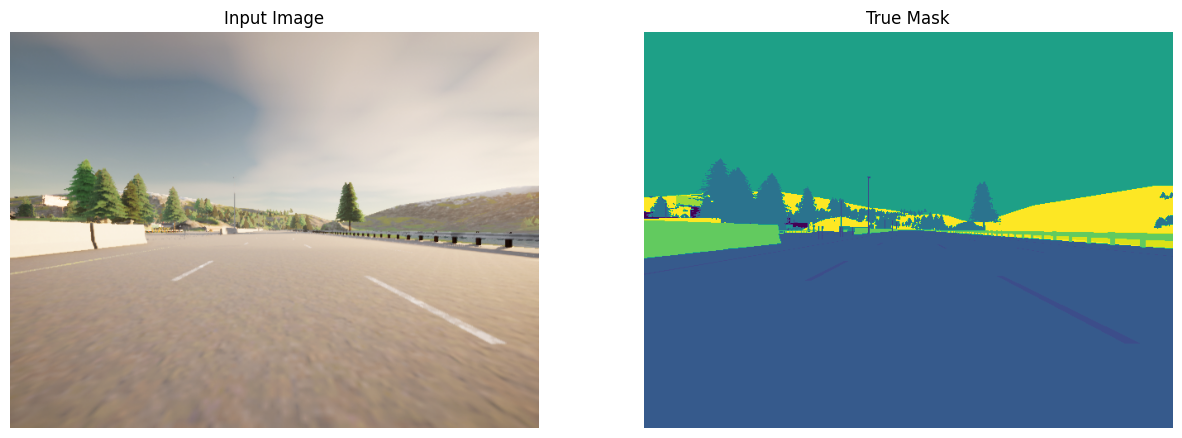

In [14]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


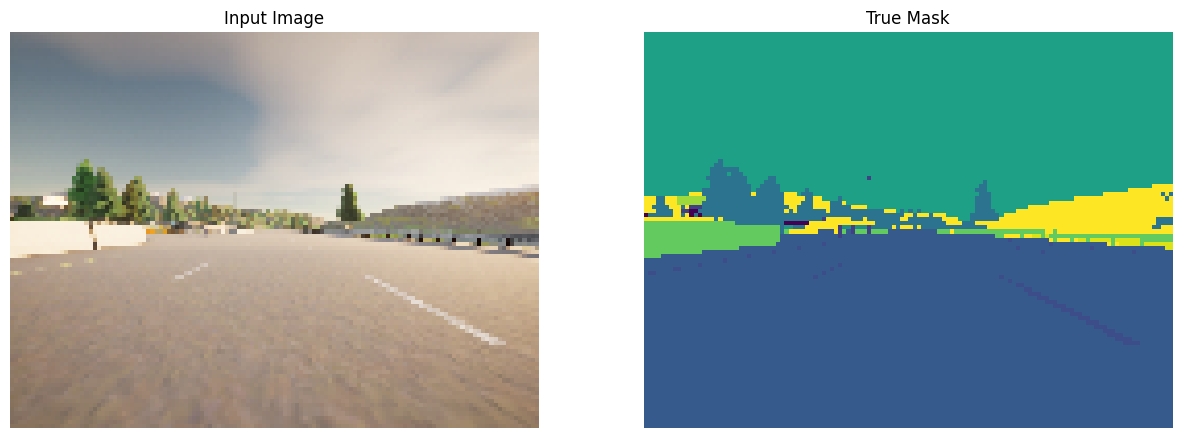

In [15]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [16]:
EPOCHS = 15
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 4

train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

model_history = model.fit(train_dataset, epochs=EPOCHS)

Epoch 1/15


C:\Users\Tanma\AppData\Roaming\Python\Python310\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


261/261 [==============================] - 26s 66ms/step - loss: 0.6065 - accuracy: 0.8753
Epoch 2/15
261/261 [==============================] - 17s 67ms/step - loss: 0.2378 - accuracy: 0.9344
Epoch 3/15
261/261 [==============================] - 17s 66ms/step - loss: 0.1727 - accuracy: 0.9518
Epoch 4/15
261/261 [==============================] - 17s 67ms/step - loss: 0.1418 - accuracy: 0.9597
Epoch 5/15
261/261 [==============================] - 17s 67ms/step - loss: 0.1173 - accuracy: 0.9666
Epoch 6/15
261/261 [==============================] - 17s 67ms/step - loss: 0.1028 - accuracy: 0.9707
Epoch 7/15
261/261 [==============================] - 17s 67ms/step - loss: 0.1082 - accuracy: 0.9684
Epoch 8/15
261/261 [==============================] - 17s 67ms/step - loss: 0.0866 - accuracy: 0.9746
Epoch 9/15
261/261 [==============================] - 19s 72ms/step - loss: 0.0767 - accuracy: 0.9773
Epoch 10/15
261/261 [==============================] - 17s 66ms/step - loss: 0.0970 - accurac

In [17]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

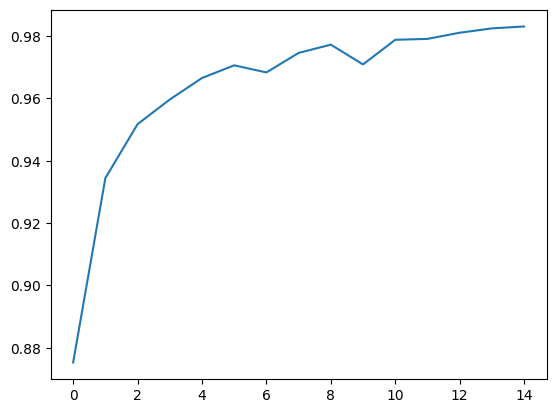

In [18]:
plt.plot(model_history.history["accuracy"])

In [19]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 510ms/step


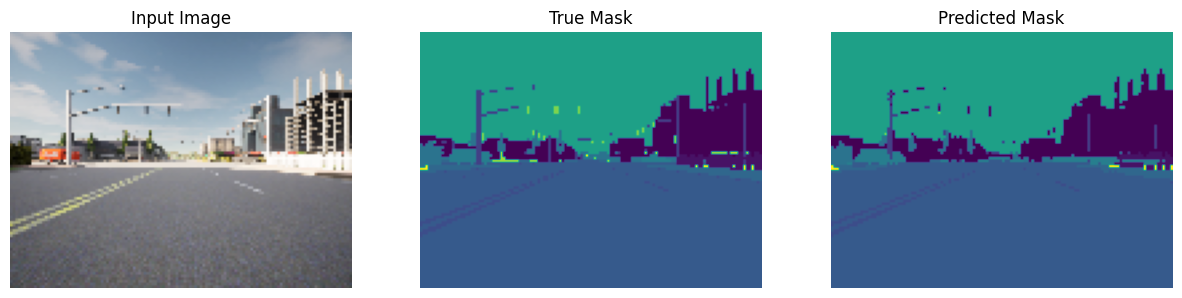

1/1 [==============================] - 0s 28ms/step


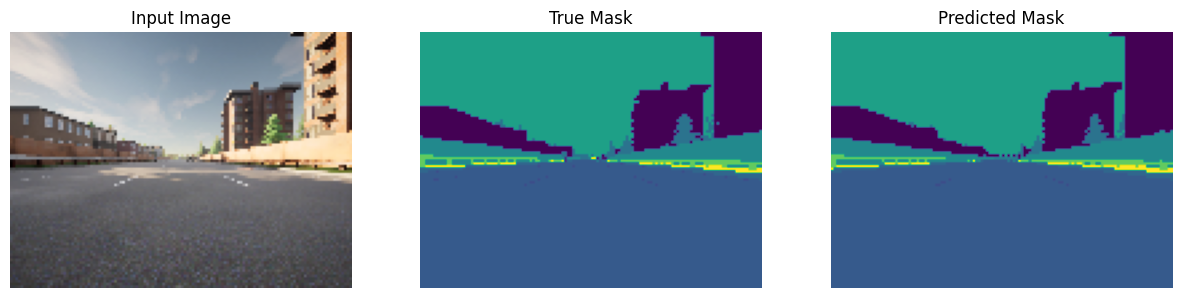

1/1 [==============================] - 0s 43ms/step


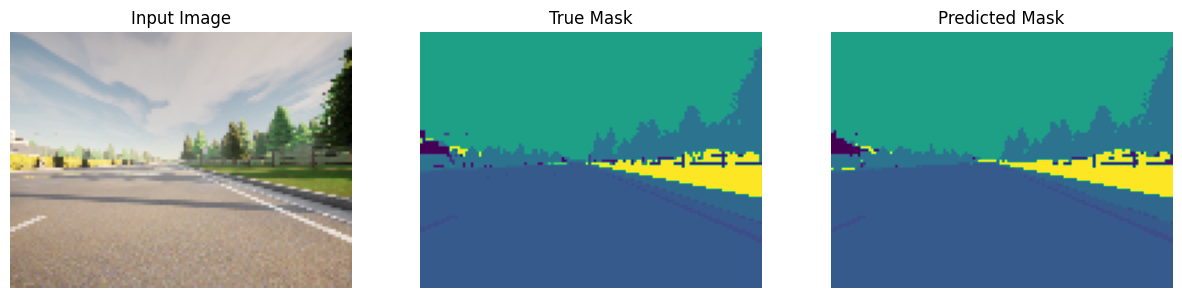

1/1 [==============================] - 0s 49ms/step


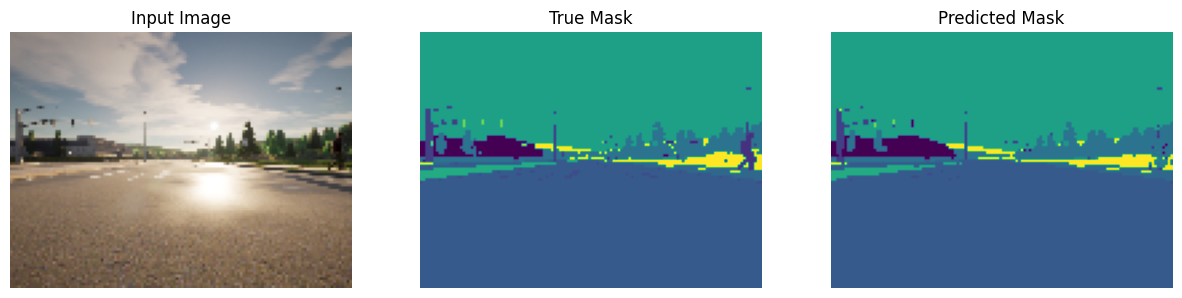

1/1 [==============================] - 0s 28ms/step


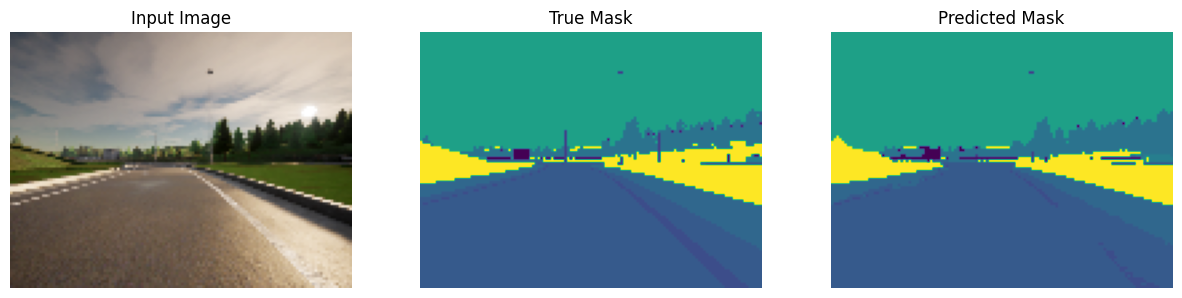

1/1 [==============================] - 0s 46ms/step


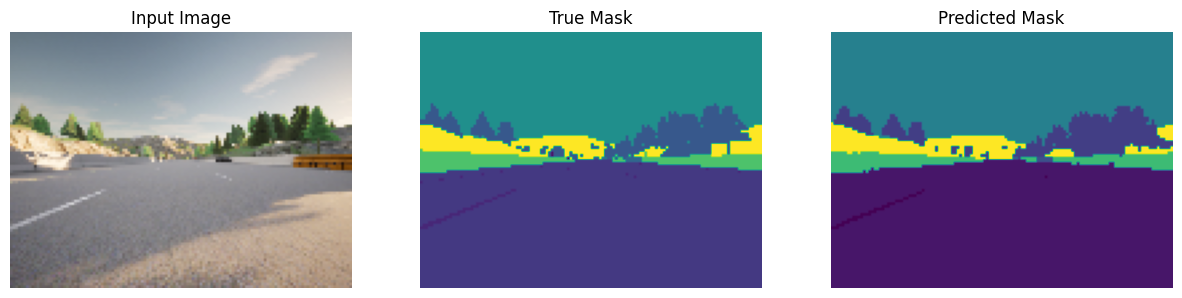

In [20]:
show_predictions(train_dataset, 6)

In [21]:
def preprocess_test(image):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    return input_image

1/1 [==============================] - 0s 51ms/step


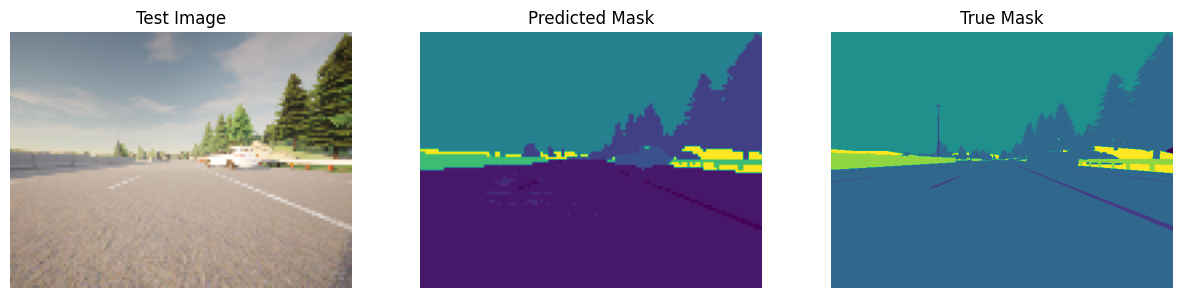

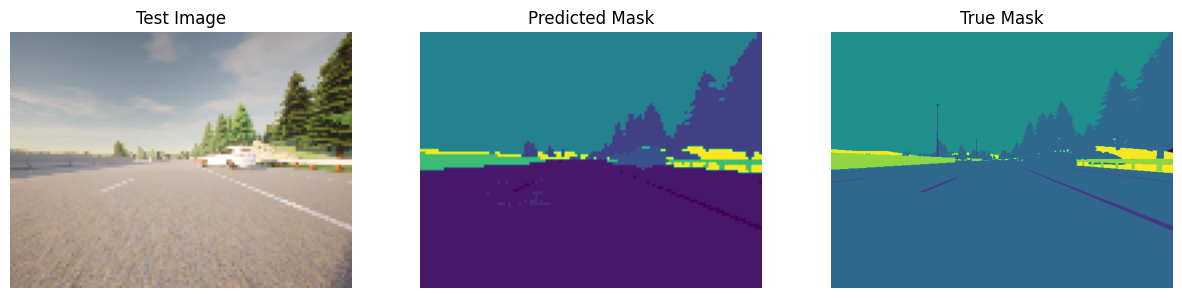

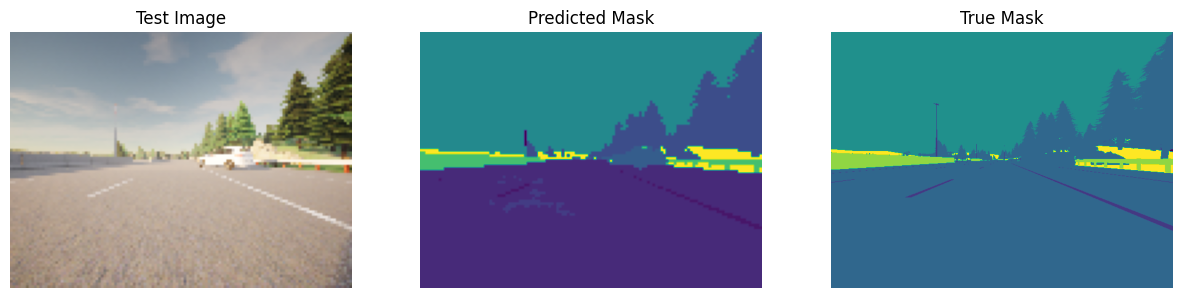

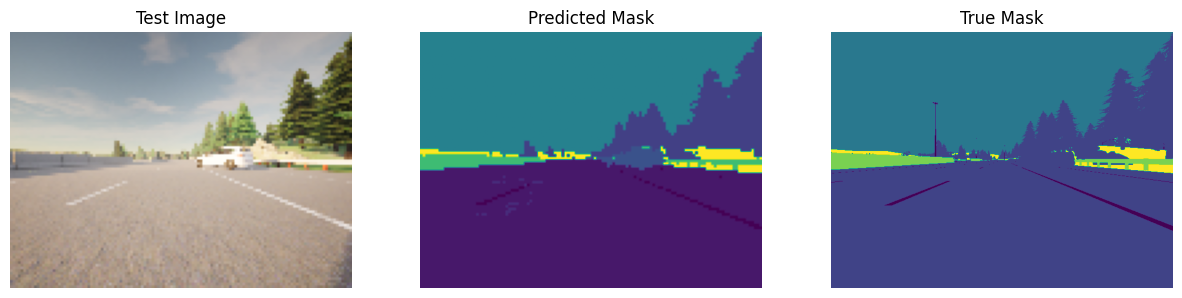

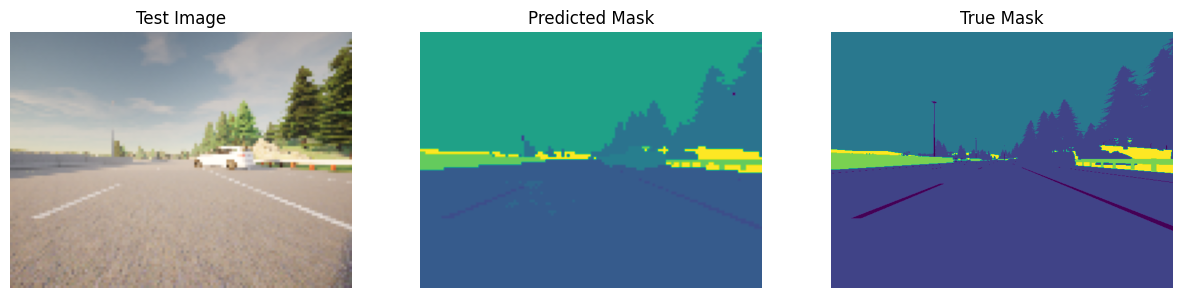

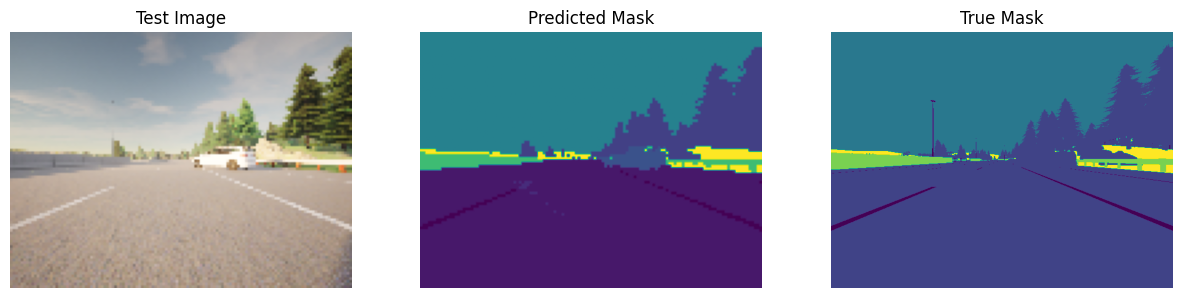

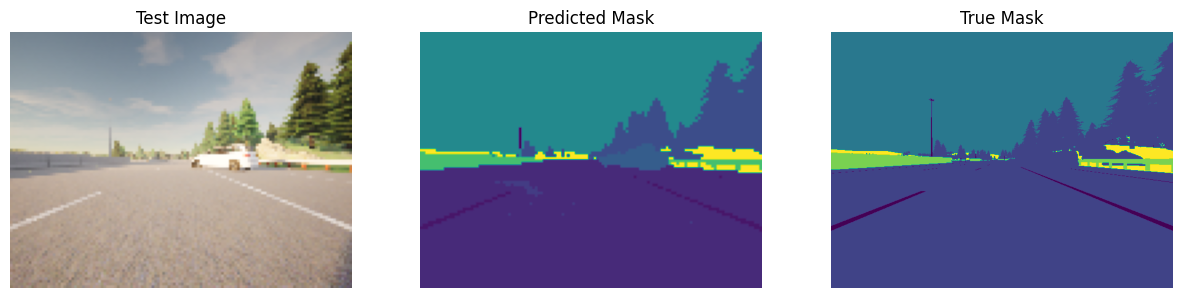

In [22]:
import os
import cv2  # Assuming you're using OpenCV to load images
import numpy as np
import tensorflow as tf

# Assuming test_masks_folder contains the ground truth masks
test_masks_folder = "test_masks"

# Load ground truth masks
true_masks = []
for image_path in test_image_list:
    mask_path = os.path.join(test_masks_folder, os.path.basename(image_path))
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_masks.append(true_mask)

# Make predictions using the trained model
pred_masks = []
for test_image in test_image_ds.take(len(test_image_list)):
    test_image = test_image[tf.newaxis, ...]
    pred_mask = model.predict(test_image)
    pred_masks.append(pred_mask)

def create_rgb_mask(mask):
    """
    Converts a single-channel mask to a three-channel RGB mask
    """
    return cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

def convert_mask_color(mask, color_scheme):
    """
    Converts a mask's color scheme according to the given color_scheme dictionary
    """
    converted_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)  # Create an empty RGB mask
    for value in color_scheme:
        converted_mask[mask == value] = color_scheme[value]
    return converted_mask

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def show_test_predictions(test_images_preprocessed, pred_masks, true_masks, num=1):
    """
    Displays the first num images of the test set along with predicted and ground truth masks
    """
    cmap = plt.cm.viridis  # Use the 'viridis' colormap

    for i, (test_image, pred_mask, true_mask) in enumerate(zip(test_images_preprocessed, pred_masks, true_masks)):
        if i >= num:
            break
        
        display_list = [test_image, create_mask(pred_mask), true_mask]
        title = ['Test Image', 'Predicted Mask', 'True Mask']
        display(display_list, title, cmap)

def display(display_list, title=None, cmap=None):
    """
    Displays a list of images with their corresponding titles
    """
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if cmap is not None and i == len(display_list) - 1:  # Apply colormap only to the last image
            plt.imshow(display_list[i], cmap=cmap)
        else:
            plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

# Display predictions for the test set along with ground truth
show_test_predictions(test_image_ds, pred_masks, true_masks, num=7)
